# Two time correlation example notebook

In [1]:
import skbeam.core.correlation as corr
from skbeam.core.correlation import two_time_corr, two_time_state_to_results
import skbeam.core.roi as roi
import skbeam.core.utils as utils

from xray_vision.mpl_plotting.roi import show_label_array_on_image

import numpy as np
import time as ttime
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# multi-tau scheme info
real_data_levels = 7
real_data_bufs = 8
real_data = np.load("100_500_NIPA_GEL.npy")

avg_img = np.average(real_data, axis=0)

# generate some circular ROIs
# define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), real_data.shape[1:])

<IPython.core.display.Javascript object>


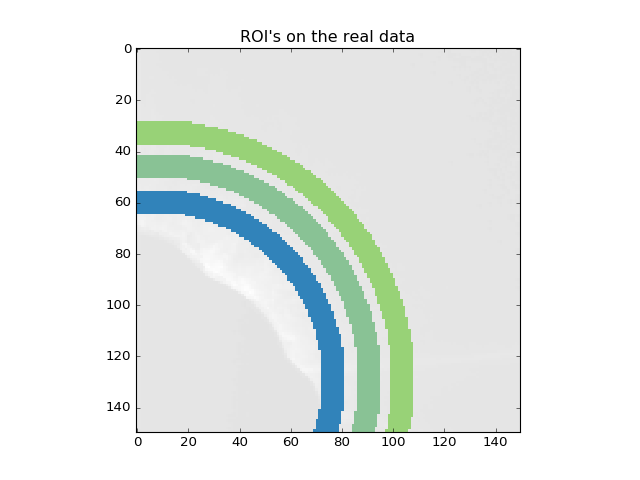

In [3]:
fig, ax = plt.subplots()
ax.imshow(np.sum(real_data, axis=0) / len(real_data))
show_label_array_on_image(ax, avg_img, labeled_roi_array)
plt.title("ROI's on the real data")
plt.show()

### Brute force correlation
- set `num_levs` to 1 and `num_bufs` to the number of images you want to correlate

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
def make_image_grid(im_shape):
    """Create the image grid with colorbars"""
    def _add_inner_title(ax, title, loc, size=None, **kwargs):
        """Add a title on top of the image"""
        from matplotlib.offsetbox import AnchoredText
        from matplotlib.patheffects import withStroke
        if size is None:
            size = dict(size=plt.rcParams['legend.fontsize'])
        at = AnchoredText(title, loc=loc, prop=size,
                          pad=0., borderpad=0.5,
                          frameon=False, **kwargs)
        ax.add_artist(at)
        at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
        return at
    fig = plt.figure(None, (10, 8))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 2),
                     direction="row",
                     axes_pad=0.05,
                     add_all=True,
                     label_mode="1",
                     share_all=True,
                     cbar_location="top",
                     cbar_mode="each",
                     cbar_size="7%",
                     cbar_pad="1%",
                     )
    ims = []
    for ax, im_title in zip(grid, ["Ring 1", "Ring 2"]):
        t = _add_inner_title(ax, im_title, loc=2)
        t.patch.set_alpha(0.5)
        ax.set_xlabel('t1')
        ax.set_ylabel('t2')
        im = ax.imshow(np.zeros(im_shape), 
                       cmap='viridis', origin="lower")
        ims.append(im)
        ax.cax.colorbar(im)
    return grid, ims

def update_plots(grid, ims, g2s):
    """Update the plot as the correlation is running"""
    for ax, im, g2 in zip(grid, ims, g2s):
        im.set_data(g2)
        ax.cax.colorbar(im)
        lo, hi = np.min(g2), np.max(g2)
        # low bound should be at least one
        lo = lo if lo > 1 else 1
        # high bound should be at least the low bound
        hi = lo if hi < lo else hi
        im.set_clim(lo, hi)
    ax.figure.canvas.draw()    
    ttime.sleep(0.01)

## Using the NIPA gel data

In [6]:
num_levs = 1
num_bufs = real_data.shape[0]
full_gen = corr.lazy_two_time(labeled_roi_array, real_data, 
                              real_data.shape[0], num_bufs, num_levs)

<IPython.core.display.Javascript object>


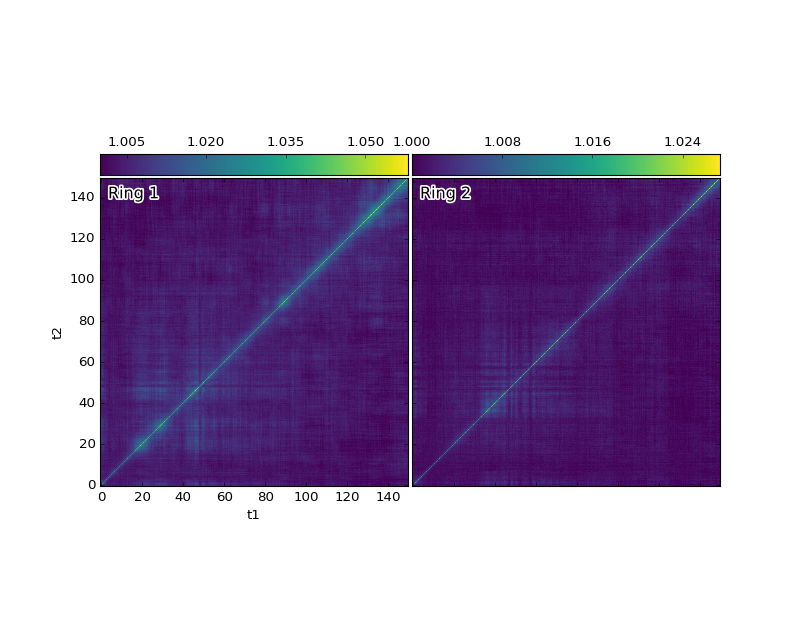

processing 0
processing 25
processing 50
processing 75
processing 100
processing 125
processing 150
processing 175
processing 200
processing 225
processing 250
processing 275
processing 300
processing 325
processing 350
processing 375
processing 400
processing 425
processing 450
processing 475


/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


In [7]:
grid, ims = make_image_grid(real_data.shape[1:])
for idx, intermediate_state1 in enumerate(full_gen):
    if idx % 25 == 0:
        print('processing %s' % idx)
        result1 = corr.two_time_state_to_results(intermediate_state1)
        update_plots(grid, ims, result1.g2)
# provide a final update
result1 = corr.two_time_state_to_results(intermediate_state1)
update_plots(grid, ims, result1.g2)


## Multi tau two time correlation

###  For Multi tau two time correlation you can give the number of levels any number
### you want and the number of buffers has to be an evan number  
#### ( More information  : skbeam/core/corrleation.py  https://github.com/scikit-beam/scikitbeam/blob/master/skbeam/core/correlation.py

In [8]:
num_bufs = 8
num_levs = 6

In [9]:
multi_gen = corr.lazy_two_time(labeled_roi_array, real_data, real_data.shape[0],
                            num_bufs, num_levs)

<IPython.core.display.Javascript object>


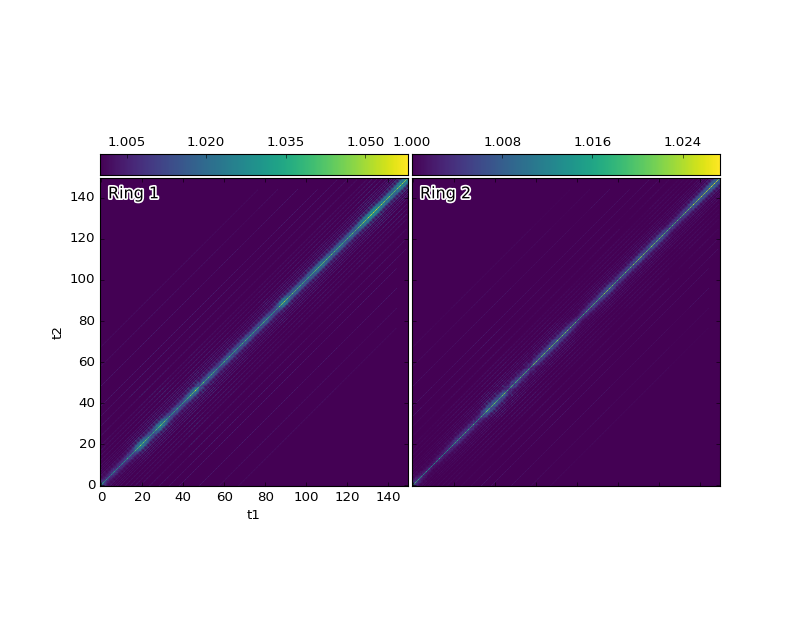

processing 0
processing 25
processing 50
processing 75
processing 100
processing 125
processing 150
processing 175
processing 200
processing 225
processing 250
processing 275
processing 300
processing 325
processing 350
processing 375
processing 400
processing 425
processing 450
processing 475


/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


In [10]:
grid, ims = make_image_grid(real_data.shape[1:])
for idx, intermediate_state in enumerate(multi_gen):
    if idx % 25 == 0:
        print('processing %s' % idx)
        m_result = corr.two_time_state_to_results(intermediate_state)
        update_plots(grid, ims, m_result.g2)
        ttime.sleep(0.01)
#provide a final update
result = corr.two_time_state_to_results(intermediate_state)
update_plots(grid, ims, result.g2)


In [66]:
import skbeam
print(skbeam.__version__)

0.0.7+28.gdaf27c4
